In [1]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 5.3 MB/s eta 0:00:00


In [1]:

import tensorflow as tf
import keras
from keras import layers
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomBrightness, RandomCrop, RandomContrast,RandomTranslation
import os
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from tensorflow.keras.applications import EfficientNetB0
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, accuracy_score
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import roc_curve, auc
from collections import Counter
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import LearningRateScheduler, ReduceLROnPlateau
import keras_tuner
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tensorflow.keras import layers, models
from tensorflow.keras import Input
from sklearn.svm import SVC
from keras.saving import register_keras_serializable
from tensorflow.keras import layers, Model, Input
import keras_tuner as kt
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras import regularizers
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.patches as patches
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split

# Part 1:  Data Analysis





In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# loading the dataset
data_path = r'/content/drive/MyDrive/RealWaste 1'
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_path,
    image_size=(224, 224),
    batch_size=32

)


Found 3734 files belonging to 8 classes.


In [4]:
# counting the number of class and getting the class names
class_names = sorted(os.listdir(data_path))
num_classes = len(class_names)
class_counts = np.zeros(num_classes)

In [5]:
# applying data augmentation
data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal_and_vertical"),
    RandomRotation(0.2),
    RandomZoom(0.2),
    RandomBrightness(0.2),
    RandomCrop(224, 224),
])

def augment(image, label):

    image = data_augmentation(image)
    image = tf.image.resize(image, (224, 224))
    return image , label



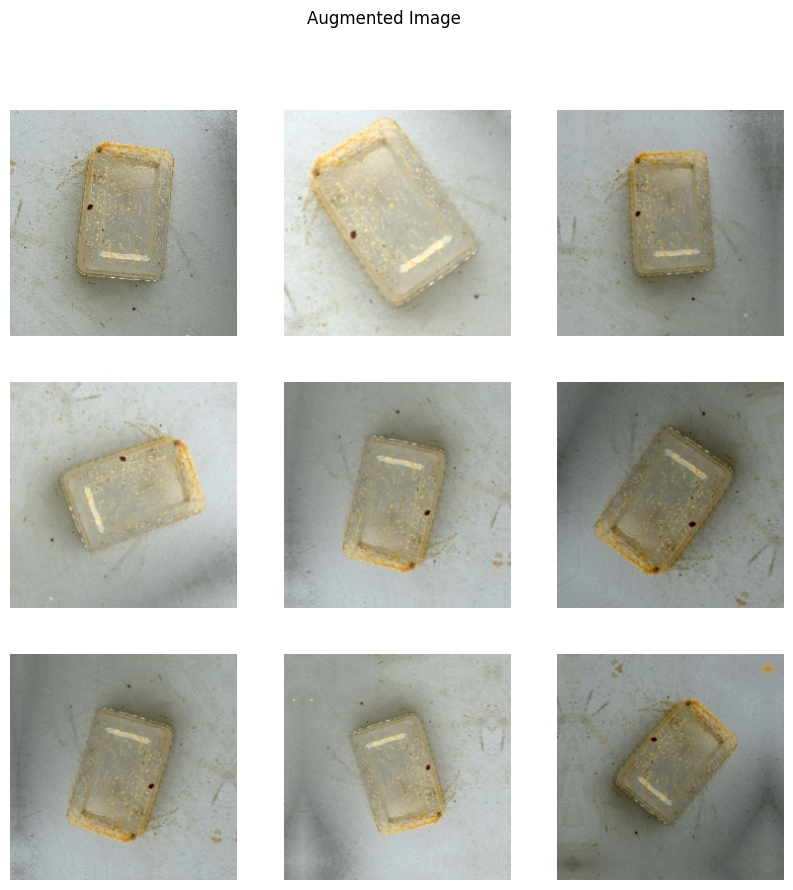

In [6]:
# visualizing the augmented images
def visualize_dataset(dataset, class_names):
    plt.figure(figsize=(10, 10))
    for images, labels in dataset.take(1):
          image = images[0]


    augmented_images = [image]
    for _ in range(8):
        augmented_images.append(data_augmentation(image[tf.newaxis, ...])[0])


    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        img = augmented_images[i].numpy().astype("uint8")
        plt.imshow(img)
        plt.axis("off")
    plt.suptitle('Augmented Image')
    plt.show()


visualize_dataset(dataset, class_names)

In [7]:
# normalizing and the images and converting the label to one hot encoding
def normalize_and_encode(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    label = tf.cast(label, tf.int32)
    label = tf.one_hot(label, num_classes)
    return image, label


In [8]:
# getting the lenght of the dataset
dataset_size = tf.data.experimental.cardinality(dataset).numpy()

In [117]:
shuffled_dataset = dataset.shuffle(buffer_size=dataset_size, seed=42, reshuffle_each_iteration=False)
shuffled_dataset = shuffled_dataset.cache()

# getting the split for traing, val and testing
train_size = int(0.7 * dataset_size)
val_size = int(0.15 * dataset_size)

# splitting the data
train_dataset = shuffled_dataset.take(train_size).map(augment).map(normalize_and_encode)
remaining_dataset = shuffled_dataset.skip(train_size)
val_dataset = remaining_dataset.take(val_size).map(normalize_and_encode)
test_dataset = remaining_dataset.skip(val_size).map(normalize_and_encode)

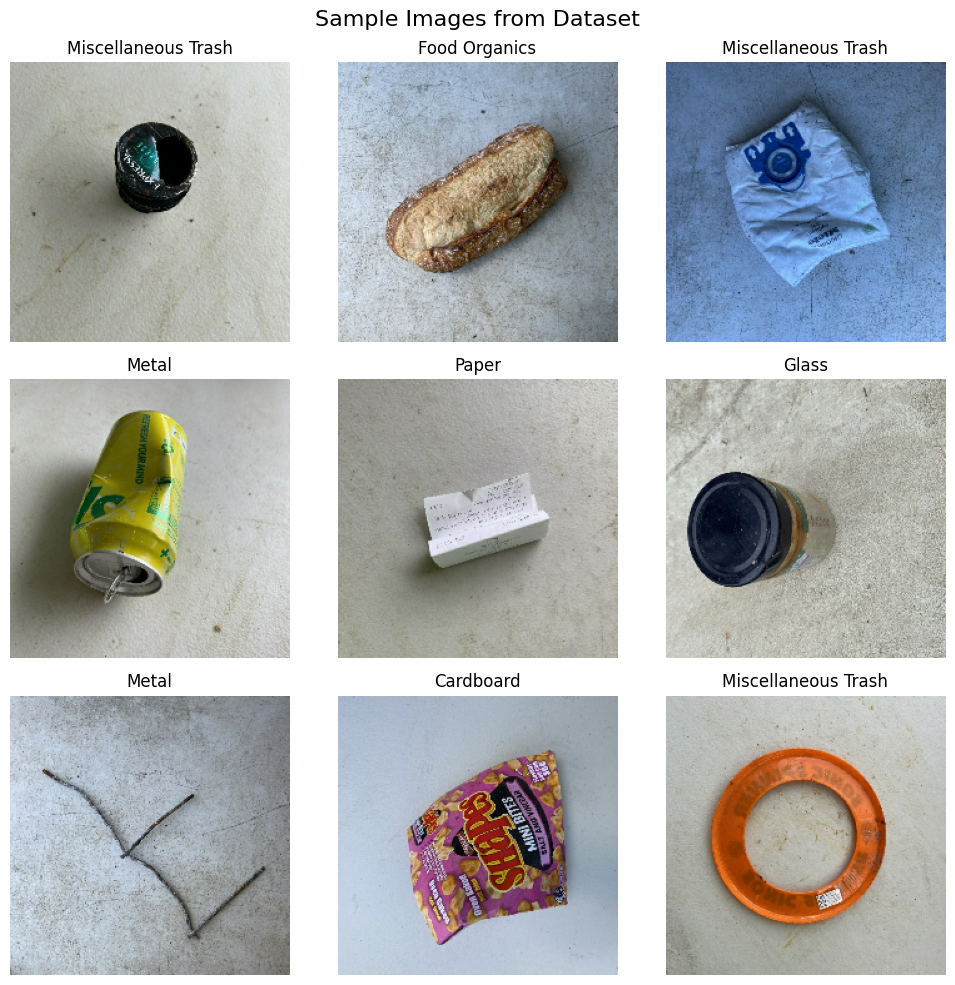

In [118]:
# visualizing the dataset
plt.figure(figsize=(10, 10))

for images, labels in dataset.take(1):
  for i in range(9):
    image = images[i]
    label_idx = labels[i].numpy()

    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().astype("uint8"))
    plt.title(class_names[label_idx])
    plt.axis("off")

plt.suptitle("Sample Images from Dataset", fontsize=16)
plt.tight_layout()
plt.show()

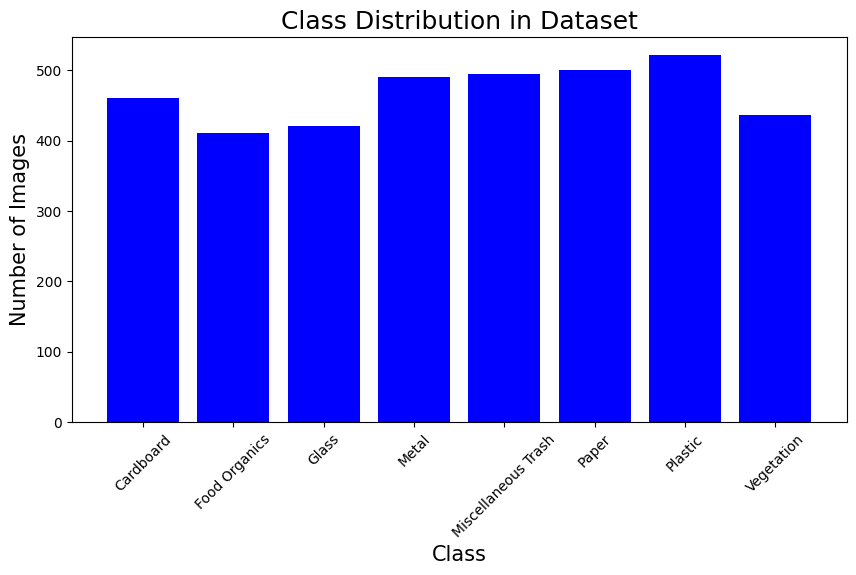

In [119]:
# visualizing the class distribution

class_counts = {class_name: len(os.listdir(os.path.join(data_path, class_name)))
                for class_name in class_names}


plt.figure(figsize=(10, 5))
plt.bar(class_counts.keys(), class_counts.values(), color='blue')
plt.xticks(rotation=45)
plt.xlabel("Class", fontsize = 15 )
plt.ylabel("Number of Images", fontsize = 15 )
plt.title("Class Distribution in Dataset", fontsize = 18 )
plt.show()


# Part 2: EfficientNet B0

In [120]:
# adding exponential decay of learning rate and calling learning rate scheduler
def scheduler(epoch, lr):
    min_lr = 1e-5
    if epoch < 5:
        return lr
    else:
        new_lr = float(lr * tf.math.exp(-0.1))
        return max(new_lr, min_lr)
lr_scheduler = LearningRateScheduler(scheduler)


In [121]:
# adding early stopping
early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True,
    verbose=1
)

In [122]:

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

In [123]:
# loading the efficientnetb0 model and the imagenet weights
base_model = EfficientNetB0(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
# making all base the layers trainable
base_model.trainable = True

# adding the fully connected dense layer
model_base = keras.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dropout(0.60),
    layers.Dense(256, activation="relu",),
    layers.Dense(8, activation="softmax")
])


# compiling the model
model_base.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-5),
              loss= 'CategoricalCrossentropy',
              metrics=["accuracy"])


# traing the model
history_base_model = model_base.fit(train_dataset, validation_data=val_dataset, epochs=35,  callbacks=[ lr_scheduler, reduce_lr])


Epoch 1/35
81/81 ━━━━━━━━━━━━━━━━━━━━ 115s 490ms/step - accuracy: 0.1340 - loss: 3.8768 - val_accuracy: 0.1066 - val_loss: 2.1667 - learning_rate: 1.0000e-05
Epoch 2/35
81/81 ━━━━━━━━━━━━━━━━━━━━ 42s 450ms/step - accuracy: 0.1767 - loss: 3.3542 - val_accuracy: 0.1029 - val_loss: 2.2364 - learning_rate: 1.0000e-05
Epoch 3/35
81/81 ━━━━━━━━━━━━━━━━━━━━ 42s 450ms/step - accuracy: 0.2503 - loss: 3.0417 - val_accuracy: 0.1029 - val_loss: 2.3092 - learning_rate: 1.0000e-05
Epoch 4/35
81/81 ━━━━━━━━━━━━━━━━━━━━ 43s 452ms/step - accuracy: 0.2679 - loss: 2.7466 - val_accuracy: 0.1287 - val_loss: 2.4069 - learning_rate: 1.0000e-05
Epoch 5/35
81/81 ━━━━━━━━━━━━━━━━━━━━ 42s 452ms/step - accuracy: 0.2899 - loss: 2.5419 - val_accuracy: 0.1618 - val_loss: 2.5842 - learning_rate: 5.0000e-06
Epoch 6/35
81/81 ━━━━━━━━━━━━━━━━━━━━ 42s 450ms/step - accuracy: 0.3159 - loss: 2.3686 - val_accuracy: 0.2574 - val_loss: 2.2805 - learning_rate: 1.0000e-05
Epoch 7/35
81/81 ━━━━━━━━━━━━━━━━━━━━ 42s 448ms/step - ac

In [124]:
model_base.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 8)              │         2,056 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,064,885 (49.84 MB)

 Trainable params: 4,340,100 (16.56 MB)

 Non-trainable params: 44,583 (174.16 KB)

 Optimizer params: 8,680,202 (33.11 MB)

In [125]:
# saving the model
model_base.save('/content/drive/MyDrive/my_basemodel.keras')

In [126]:

# creating lists to store true labels and predicted probabilities
y_true_base = []
y_pred_probs_base = []


# loop over validation dataset to collect predictions and true labels
for images, labels in val_dataset:
    preds = model_base.predict(images)
    y_true_base.extend(labels.numpy())
    y_pred_probs_base.extend(preds)
# convert lists to NumPy arrays
y_pred_probs_base = np.array(y_pred_probs_base)
y_true_base = np.array(y_true_base)

# convert predicted probabilities to predicted class indices
y_pred_base = np.argmax(y_pred_probs_base, axis=1)



1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


In [127]:
# convert one-hot encoded true labels to class indices
if y_true_base.ndim > 1:
    y_true_base = np.argmax(y_true_base, axis=1)


print(classification_report(y_true_base, y_pred_base))

              precision    recall  f1-score   support

           0       0.70      0.74      0.72        69
           1       0.85      0.82      0.84        68
           2       0.76      0.41      0.53        68
           3       0.73      0.79      0.76        62
           4       0.75      0.63      0.68        67
           5       0.72      0.80      0.76        76
           6       0.59      0.74      0.66        74
           7       0.85      0.95      0.90        60

    accuracy                           0.73       544
   macro avg       0.74      0.74      0.73       544
weighted avg       0.74      0.73      0.73       544



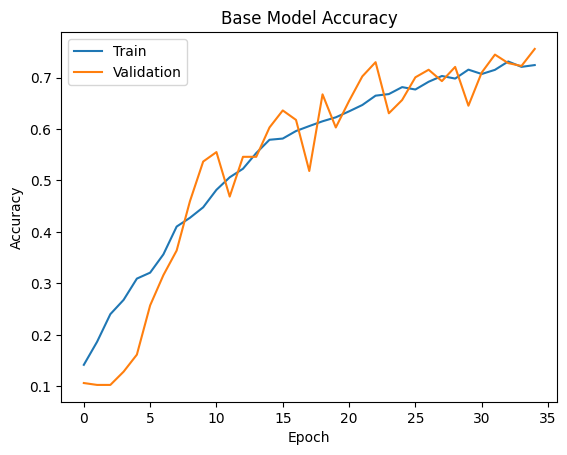

In [128]:
# plotting the accuracy graph
def plot_hist(history):
    plt.plot(history_base_model.history["accuracy"])
    plt.plot(history_base_model.history["val_accuracy"])
    plt.title("Base Model Accuracy")
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.legend(["Train", "Validation"], loc="upper left")
    plt.show()


plot_hist(history_base_model)

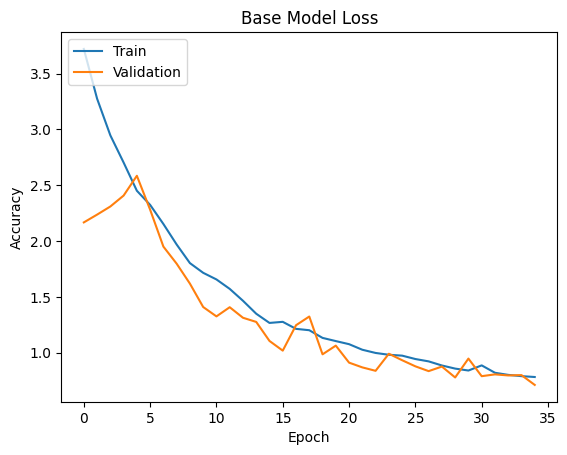

In [129]:
# plotting the loss graph
def plot_hist(history):
    plt.plot(history_base_model.history["loss"])
    plt.plot(history_base_model.history["val_loss"])
    plt.title("Base Model Loss")
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.legend(["Train", "Validation"], loc="upper left")
    plt.show()


plot_hist(history_base_model)

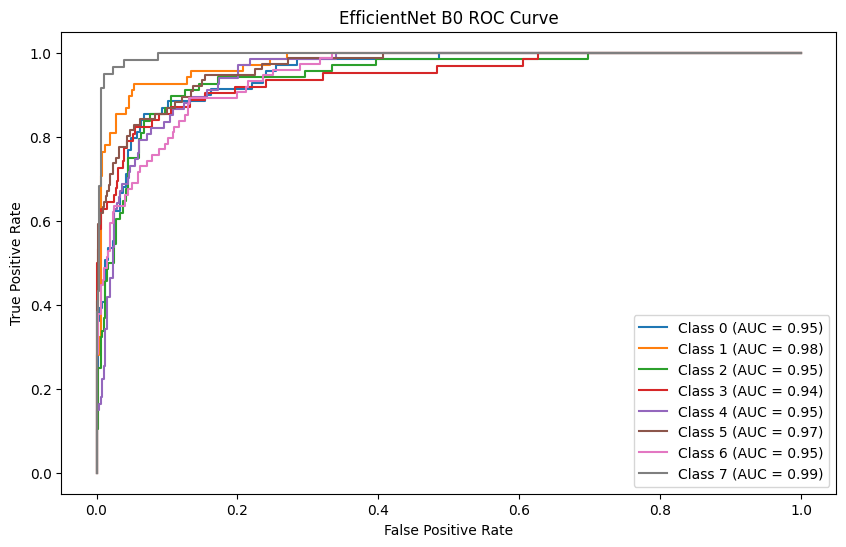

In [130]:
num_classes = 8
# converting the true class indices to one-hot encoded
y_true_one_hot = to_categorical(y_true_base, num_classes)

plt.figure(figsize=(10, 6))

for i in range(num_classes):
    # calculate FPR and TPR
    fpr, tpr, _ = roc_curve(y_true_one_hot[:, i], y_pred_probs_base[:, i])
    roc_auc = auc(fpr, tpr)
    # plotting the ROC curve
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')



plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("EfficientNet B0 ROC Curve")
plt.legend(loc='lower right')
plt.show()

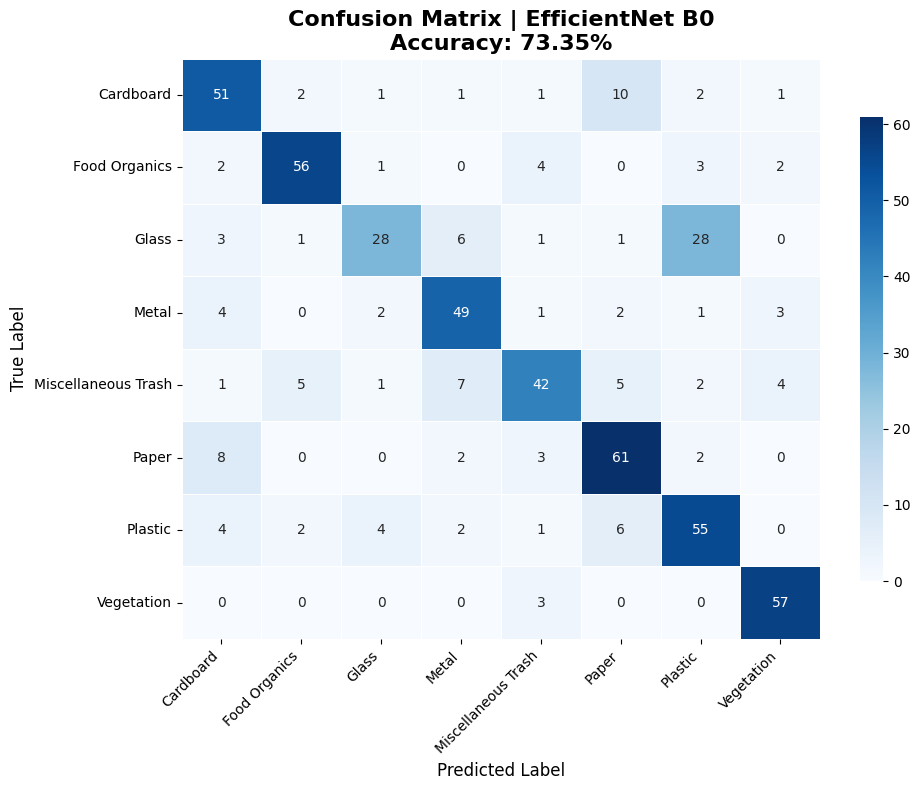

In [131]:
# function to plot confusion matrix with heatmap and accuracy display
def plot_confusion_matrix(y_true, y_pred, class_names, model_name="EfficientNet B0"):
    # Compute the confusion matrix and accuracy
    cm = confusion_matrix(y_true_base, y_pred_base)
    acc = accuracy_score(y_true_base, y_pred_base) * 100

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", linewidths=0.5,
                xticklabels=class_names, yticklabels=class_names, cbar_kws={'shrink': 0.8})

    plt.xlabel("Predicted Label", fontsize=12)
    plt.ylabel("True Label", fontsize=12)
    plt.title(f"Confusion Matrix | {model_name}\nAccuracy: {acc:.2f}%", fontsize=16, fontweight='bold')
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.yticks(rotation=0, fontsize=10)
    plt.tight_layout()
    plt.show()
# displaying the plot
plot_confusion_matrix(y_true_base, y_pred_base, class_names, model_name="EfficientNet B0")

In [132]:
# loading the saved model
model_base = load_model(
    "/content/drive/MyDrive/my_basemodel.keras",
)

In [133]:

test_loss_base, test_acc_base = model_base.evaluate(test_dataset)


print(f"Test Accuracy: {test_acc_base:.4f}")
print(f"Test Loss: {test_loss_base:.4f}")

19/19 ━━━━━━━━━━━━━━━━━━━━ 18s 216ms/step - accuracy: 0.7351 - loss: 0.7842
Test Accuracy: 0.7274
Test Loss: 0.8260


In [134]:

def classify_from_dataset(model, test_dataset, class_names, num_images=9):
    plt.figure(figsize=(12, 12))

    for images, labels in test_dataset.take(1):
        # get the predictions
        predictions = model_base.predict(images, verbose=0)

        for i in range(min(num_images, len(images))):
            image = images[i]
            # convert one-hot to label index
            true_label = tf.argmax(labels[i]).numpy()
            prob_vector = predictions[i]
            # get predicted class index
            pred_label = np.argmax(prob_vector)

            ax = plt.subplot(3, 3, i + 1)

            # convert image to uint8 if normalized
            img = image.numpy()
            if img.max() <= 1.0:
                img = (img * 255).astype("uint8")
            else:
                img = img.astype("uint8")

            ax.imshow(img)
            ax.axis("off")

            # set title color to be green if correct, red if incorrect
            title_color = "green" if pred_label == true_label else "red"
            ax.set_title(
                f"Pred: {class_names[pred_label]}\nTrue: {class_names[true_label]}",
                fontsize=10,
                color=title_color
            )

            # display top-3 predicted classes with probabilities
            top3 = np.argsort(prob_vector)[-3:][::-1]
            prob_text = "\n".join([f"{class_names[j]}: {prob_vector[j]*100:.1f}%" for j in top3])
            ax.text(0.5, -0.25, prob_text, transform=ax.transAxes,
                    ha='center', va='top', fontsize=8,
                    bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

    plt.suptitle("Efficientnet B0 Classification with Top 3 Probabilities", fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    plt.show()


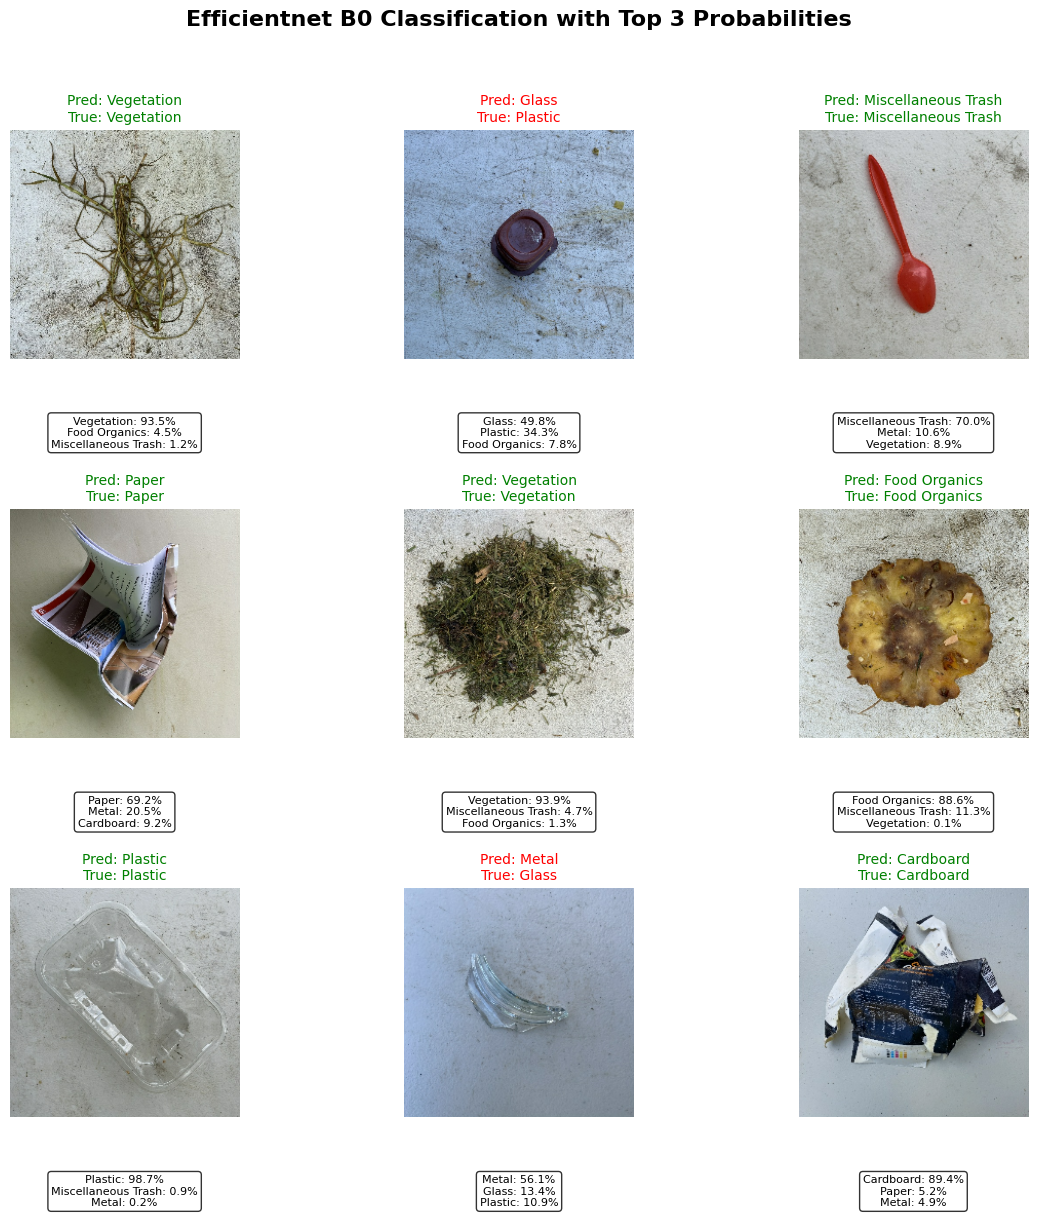

In [135]:
# plotting the predictions
classify_from_dataset(model_base, test_dataset, class_names)


# Part 3: Hyperparameter Tuned EfficientNet B0

In [136]:
# building the hyperparameter tuned model
def build_model(hp):
    base_model = keras.applications.EfficientNetB0(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

    # setting the base layers to trainable
    base_model.trainable = True

    # setting the optimizer choice and the learning rate choice
    optimizer_choice = hp.Choice("optimizer", ["adam", "rmsprop"])
    optimizer = {
        "adam": keras.optimizers.Adam,
        "rmsprop": keras.optimizers.RMSprop
    }[optimizer_choice](learning_rate=hp.Choice("learning_rate", [ 1e-3, 1e-4, 1e-5]))

    # setting the choice for fully connected layer
    model_tuned = keras.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.BatchNormalization(),
        layers.Dropout(hp.Float("dropout_rate", min_value=0.4, max_value=0.8, step=0.1)),
        layers.Dense(hp.Int("units", min_value=64, max_value=512, step=64),
                     activation=hp.Choice("activation", ["relu", "elu", "swish"]),
                     kernel_regularizer=tf.keras.regularizers.l2(
                         hp.Float("l2", min_value=0.001, max_value=0.01, step=0.001))),
        layers.Dense(8, activation="softmax")
    ])

    # compiling the model
    model_tuned.compile(
        optimizer=optimizer,
        loss='CategoricalCrossentropy',
        metrics=["accuracy"]
    )
    return model_tuned



In [165]:
rm -rf hyperparameter_tuning/efficientnet_tuning/


In [166]:
# initializing random search for finding the perfect hyperparameters
tuner = keras_tuner.RandomSearch(
    build_model,
    objective="val_accuracy",
    max_trials=3,
    executions_per_trial=2,
    directory="hyperparameter_tuning",
    project_name="efficientnet_tuning"
)


In [172]:
# searching for the optimal hyperparameter using random search
tuner.search(train_dataset, validation_data=val_dataset, epochs=15, callbacks=[ lr_scheduler, early_stopping])


best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]




In [173]:
# saving the best model
best_model = tuner.hypermodel.build(best_hp)
# training the model
history_tuned = best_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=40,
    callbacks=[ lr_scheduler, reduce_lr]

)

Epoch 1/40
81/81 ━━━━━━━━━━━━━━━━━━━━ 100s 417ms/step - accuracy: 0.2596 - loss: 6.9115 - val_accuracy: 0.1452 - val_loss: 6.6466 - learning_rate: 1.0000e-04
Epoch 2/40
81/81 ━━━━━━━━━━━━━━━━━━━━ 31s 378ms/step - accuracy: 0.5625 - loss: 5.7793 - val_accuracy: 0.1415 - val_loss: 6.5864 - learning_rate: 1.0000e-04
Epoch 3/40
81/81 ━━━━━━━━━━━━━━━━━━━━ 30s 369ms/step - accuracy: 0.6905 - loss: 5.3433 - val_accuracy: 0.1379 - val_loss: 6.5250 - learning_rate: 1.0000e-04
Epoch 4/40
81/81 ━━━━━━━━━━━━━━━━━━━━ 31s 376ms/step - accuracy: 0.7156 - loss: 5.0737 - val_accuracy: 0.2298 - val_loss: 6.3251 - learning_rate: 1.0000e-04
Epoch 5/40
81/81 ━━━━━━━━━━━━━━━━━━━━ 30s 368ms/step - accuracy: 0.7595 - loss: 4.8003 - val_accuracy: 0.2849 - val_loss: 6.0348 - learning_rate: 1.0000e-04
Epoch 6/40
81/81 ━━━━━━━━━━━━━━━━━━━━ 31s 375ms/step - accuracy: 0.7915 - loss: 4.6180 - val_accuracy: 0.3346 - val_loss: 5.8677 - learning_rate: 9.0484e-05
Epoch 7/40
81/81 ━━━━━━━━━━━━━━━━━━━━ 30s 373ms/step - ac

In [174]:
best_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 320)            │       409,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 8)              │         2,568 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,312,373 (50.78 MB)

 Trainable params: 4,422,596 (16.87 MB)

 Non-trainable params: 44,583 (174.16 KB)

 Optimizer params: 8,845,194 (33.74 MB)

In [175]:
# saving the trained model
best_model.save('/content/drive/MyDrive/my_hyperparameter_model.keras')

In [176]:
tuner.results_summary()


Results summary
Results in hyperparameter_tuning/efficientnet_tuning
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 0 summary
Hyperparameters:
optimizer: adam
learning_rate: 0.0001
dropout_rate: 0.6000000000000001
units: 320
activation: swish
l2: 0.009000000000000001
Score: 0.7104779481887817

Trial 2 summary
Hyperparameters:
optimizer: adam
learning_rate: 0.0001
dropout_rate: 0.5
units: 192
activation: elu
l2: 0.004
Score: 0.18474264442920685

Trial 1 summary
Hyperparameters:
optimizer: rmsprop
learning_rate: 0.0001
dropout_rate: 0.7000000000000001
units: 256
activation: relu
l2: 0.009000000000000001
Score: 0.17922794073820114


In [177]:
# creating lists to store true labels and predicted probabilities
y_true = []
y_pred_probs= []

for images, labels in val_dataset:
    preds = best_model.predict(images)
    y_true.extend(labels.numpy())
    y_pred_probs.extend(preds)

y_pred_probs = np.array(y_pred_probs)
y_true = np.array(y_true)


y_pred = np.argmax(y_pred_probs, axis=1)



1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


In [178]:

if y_true.ndim > 1:
    y_true = np.argmax(y_true, axis=1)


print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.70      0.87      0.78        79
           1       0.87      0.77      0.82        70
           2       0.91      0.60      0.72        67
           3       0.77      0.82      0.79        56
           4       0.79      0.66      0.72        67
           5       0.83      0.87      0.85        71
           6       0.75      0.83      0.79        78
           7       0.87      0.95      0.91        56

    accuracy                           0.80       544
   macro avg       0.81      0.80      0.80       544
weighted avg       0.81      0.80      0.79       544



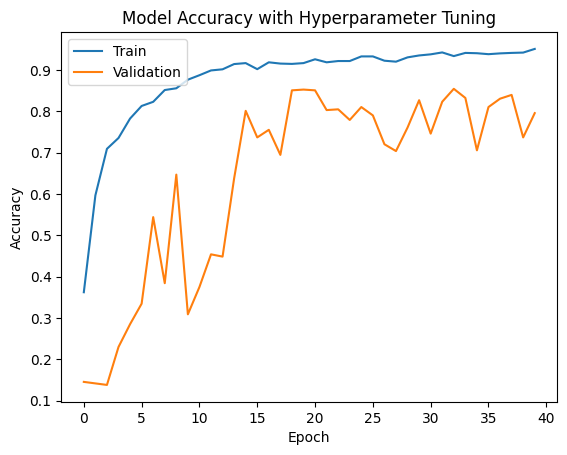

In [179]:
def plot_hist(history):
    plt.plot(history_tuned.history["accuracy"])
    plt.plot(history_tuned.history["val_accuracy"])
    plt.title("Model Accuracy with Hyperparameter Tuning")
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.legend(["Train", "Validation"], loc="upper left")
    plt.show()


plot_hist(history_tuned)

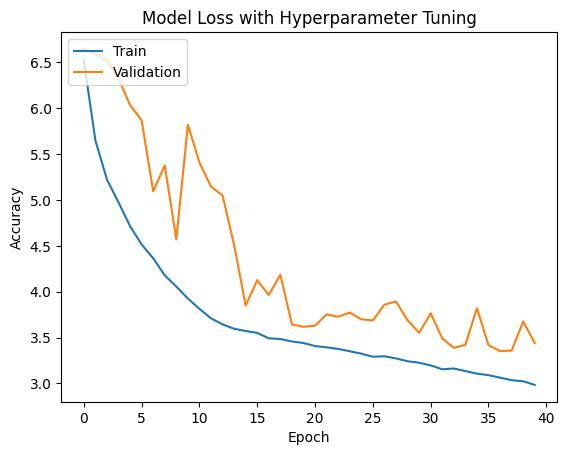

In [180]:
def plot_hist(history_tuned):
    plt.plot(history_tuned.history["loss"])
    plt.plot(history_tuned.history["val_loss"])
    plt.title("Model Loss with Hyperparameter Tuning")
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.legend(["Train", "Validation"], loc="upper left")
    plt.show()


plot_hist(history_tuned)

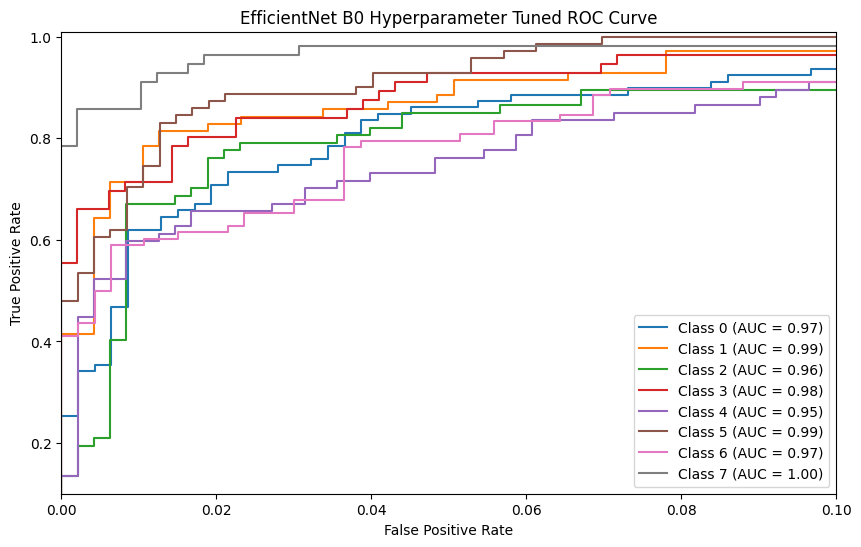

In [181]:
num_classes = 8
y_true_one_hot = to_categorical(y_true, num_classes)

plt.figure(figsize=(10, 6))

for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_one_hot[:, i], y_pred_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')


plt.xlim([0.0, 0.1])
plt.ylim([0.1, 1.01])

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("EfficientNet B0 Hyperparameter Tuned ROC Curve")
plt.legend(loc='lower right')
plt.show()

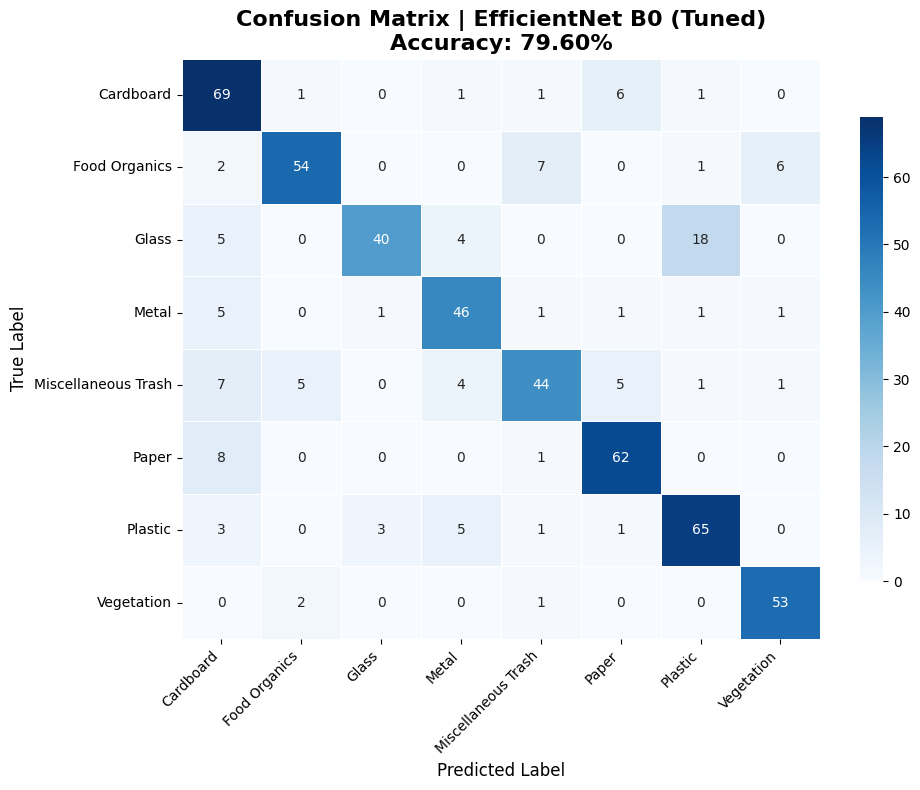

In [182]:
def plot_confusion_matrix(y_true, y_pred, class_names, model_name="EfficientNet B0 (Tuned)"):
    cm = confusion_matrix(y_true, y_pred)
    acc = accuracy_score(y_true, y_pred) * 100

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", linewidths=0.5,
                xticklabels=class_names, yticklabels=class_names, cbar_kws={'shrink': 0.8})

    plt.xlabel("Predicted Label", fontsize=12)
    plt.ylabel("True Label", fontsize=12)
    plt.title(f"Confusion Matrix | {model_name}\nAccuracy: {acc:.2f}%", fontsize=16, fontweight='bold')
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.yticks(rotation=0, fontsize=10)
    plt.tight_layout()
    plt.show()
plot_confusion_matrix(y_true, y_pred, class_names, model_name="EfficientNet B0 (Tuned)")

In [183]:
model = load_model("/content/drive/MyDrive/my_hyperparameter_model.keras")
test_loss_tuned, test_acc_tuned = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_acc_tuned:.4f}")
print(f"Test Loss: {test_loss_tuned:.4f}")

19/19 ━━━━━━━━━━━━━━━━━━━━ 12s 220ms/step - accuracy: 0.8096 - loss: 3.4045
Test Accuracy: 0.8094
Test Loss: 3.4074


In [184]:

def classify_from_dataset(model, test_dataset, class_names, num_images=9):
    plt.figure(figsize=(12, 12))

    for images, labels in test_dataset.take(1):
        predictions = model.predict(images, verbose=0)

        for i in range(min(num_images, len(images))):
            image = images[i]
            true_label = tf.argmax(labels[i]).numpy()
            prob_vector = predictions[i]
            pred_label = np.argmax(prob_vector)

            ax = plt.subplot(3, 3, i + 1)


            img = image.numpy()
            if img.max() <= 1.0:
                img = (img * 255).astype("uint8")
            else:
                img = img.astype("uint8")

            ax.imshow(img)
            ax.axis("off")


            title_color = "green" if pred_label == true_label else "red"
            ax.set_title(
                f"Pred: {class_names[pred_label]}\nTrue: {class_names[true_label]}",
                fontsize=10,
                color=title_color
            )


            top3 = np.argsort(prob_vector)[-3:][::-1]
            prob_text = "\n".join([f"{class_names[j]}: {prob_vector[j]*100:.1f}%" for j in top3])
            ax.text(0.5, -0.25, prob_text, transform=ax.transAxes,
                    ha='center', va='top', fontsize=8,
                    bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

    plt.suptitle("Hyperparameter Tuned Efficientnet B0 Classification with Top 3 Probabilities", fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    plt.show()


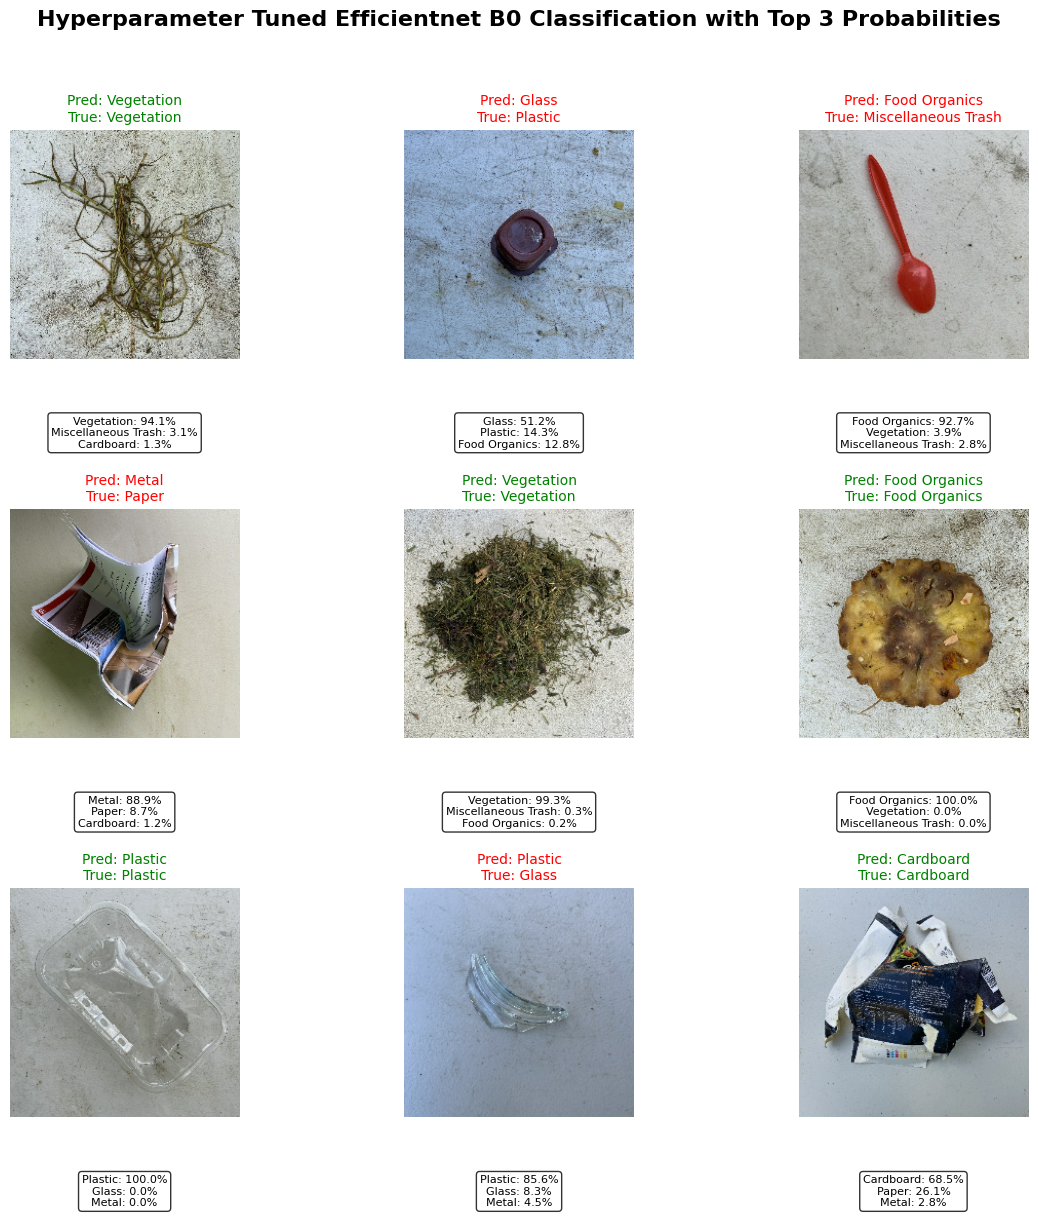

In [185]:
classify_from_dataset(model, test_dataset, class_names)
